In [1]:
%matplotlib inline
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm
import re

import sklearn.preprocessing as pre

In [2]:
COL_NOM_REGION = "Nom Région"
COL_CODE_REGION = "Code Région"

In [3]:
# Population selon le sexe et l'âge quinquennal de 1968 à 2013 (1990 à 2013 pour les DOM)
df_population_ = pd.read_excel("./pop-sexe-age-quinquennal6813.xls", sheetname="COM_2013", skiprows=12)

In [4]:
df_population = df_population_.drop(0)

In [5]:
df_population_region = df_population.groupby(df_population.columns[0], as_index=False).sum()

In [6]:
df_population_region = df_population_region.drop(df_population_region.columns[1:6], axis=1)

In [7]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
              if unicodedata.category(c) != 'Mn')

In [8]:
def normalize_region_name(name):
    norm = name.lower()
    norm = strip_accents(norm)
    norm = norm.replace("'","")
    norm = norm.strip()
    norm = re.sub(r'[^\x00-\x7F]+',"", norm)
    return norm

In [9]:
def get_region_code(name):
    return df_region_code[df_region_code[COL_NOM_REGION].str.contains(name)].iloc[0][COL_CODE_REGION]

In [10]:
def get_region_name(code):
    a = float(code)
    b = df_region_code[df_region_code[COL_CODE_REGION] == a].iloc[0][COL_NOM_REGION]
    return b

In [11]:
#  Nom / Code Region as:
#   Code Région     Nom Région
#1          1.0     guadeloupe
#2          2.0     martinique
#3          3.0         guyane
#4          4.0     la reunion
#5          6.0        mayotte
#6         11.0  ile-de-france
#7         24.0         centre
#8         26.0      bourgogne
df_region_code = pd.read_excel("./nouvelle_nomenclature_codes_regions_2016.xls", skiprows=2)
df_region_code.head(5)
df_region_code = df_region_code.drop(df_region_code.columns[0:3], axis=1)
df_region_code = df_region_code.dropna()
df_region_code.columns = [COL_CODE_REGION, COL_NOM_REGION]
df_region_code[COL_NOM_REGION] = df_region_code[COL_NOM_REGION].apply(lambda x : normalize_region_name(x))
print("Region list")
print(df_region_code.head(32))

Region list
    Code Région                 Nom Région
1           1.0                 guadeloupe
2           2.0                 martinique
3           3.0                     guyane
4           4.0                 la reunion
5           6.0                    mayotte
6          11.0              ile-de-france
7          24.0                     centre
8          26.0                  bourgogne
9          43.0              franche-comte
10         23.0            haute-normandie
11         25.0            basse-normandie
12         31.0         nord-pas-de-calais
13         22.0                   picardie
14         41.0                   lorraine
15         42.0                     alsace
16         21.0          champagne-ardenne
17         52.0           pays de la loire
18         53.0                   bretagne
19         72.0                  aquitaine
20         54.0           poitou-charentes
21         74.0                   limousin
22         73.0              midi-pyrenees

In [12]:
# Get the repartition of specialities (1 doctor can have several specialities)
df_doc_ = pd.read_csv("rpps-medecins-tableau10_30654512032814.csv", sep=',', encoding = "ISO-8859-1", header=4)
df_doc = df_doc_.dropna()
# Remove synthetical data for France, DOM, TOM
df_doc = df_doc.drop(df_doc.index[0:3])

In [13]:
# Normalize Region according to df_region_code
df_doc = df_doc.rename(columns = {df_doc.columns[0]:COL_NOM_REGION})
df_doc[COL_NOM_REGION] = df_doc[COL_NOM_REGION].apply(lambda x : normalize_region_name(x))
# Add region code
df_doc[COL_CODE_REGION] = df_doc[COL_NOM_REGION].apply(lambda x : get_region_code(x))

In [14]:
# Normalz
df_population_region = df_population_region.rename(columns = {df_population_region.columns[0]:COL_CODE_REGION}) 

In [15]:
# Create col "Nom Région"
df_population_region[COL_NOM_REGION] = df_population_region[COL_CODE_REGION].apply(lambda x : get_region_name(x))
# Normalize region code
df_population_region[COL_CODE_REGION] = df_population_region[COL_NOM_REGION].apply(lambda x : get_region_code(x))

In [16]:
def get_col_name_age_sex(age_min=0, age_max=99, sexe="MF"):
    col_name = []
    min = int(age_min / 5) * 5
    max = int(age_max / 5) * 5 + 4
    for i in range(min, max, 5):
        if 'F' in sexe:
            col_name.append("De %d à %d ans\nFemmes\nRP2013" % (i, i+4))
        if 'M' in sexe:
            col_name.append("De %d à %d ans\nHommes\nRP2013" % (i, i+4))
            
    return col_name   

In [17]:
get_col_name_age_sex(0,5, "MF")

['De 0 à 4 ans\nFemmes\nRP2013',
 'De 0 à 4 ans\nHommes\nRP2013',
 'De 5 à 9 ans\nFemmes\nRP2013',
 'De 5 à 9 ans\nHommes\nRP2013']

In [18]:
# Merge doctor list and population list
df_merge = pd.merge(df_population_region, df_doc, on=[COL_NOM_REGION])

In [19]:
df_doc.columns

Index(['Nom Région', 'Ensemble des spécialités d'exercice', 'Spécialistes',
       'Anatomie et cytologie pathologiques', 'Anesthésie-réanimation',
       'Biologie médicale', 'Cardiologie et maladies vasculaires',
       'Chirurgie générale', 'Chirurgie maxillo-faciale et stomatologie',
       'Chirurgie orthopédique et traumatologie', 'Chirurgie infantile',
       'Chirurgie plastique reconstructrice et esthétique',
       'Chirurgie thoracique et cardio-vasculaire', 'Chirurgie urologique',
       'Chirurgie vasculaire', 'Chirurgie viscérale et digestive',
       'Dermatologie et vénéréologie', 'Endocrinologie et métabolisme',
       'Génétique médicale', 'Gériatrie', 'Gynécologie médicale',
       'Gynécologie-obstétrique', 'Hématologie',
       'Gastro-entérologie et hépatologie', 'Médecine du travail',
       'Médecine interne', 'Médecine nucléaire',
       'Médecine physique et réadaptation', 'Néphrologie', 'Neuro-chirurgie',
       'Neurologie', 'O.R.L et chirurgie cervico facia

In [20]:
# Columns definition
COL_TX_PEDIATRIE = "Taux Pédiatrie (0-4 ans)"
COL_TX_GENERALISTES = "Taux Généralistes"
COL_TX_GYNECO = "Taux Gynécologie (Femmes)"
COL_TX_SPECIALISTES = "Taux Spécialistes"
COL_TX_CHIRURGIE = "Taux Chirurgie"
COL_TX_GERIATRIE = "Taux Gériatrie (> 80 ans)"
COL_TX_TOTAL = "Ensemble des spécialités"

# Create synthetic DF
df_res = pd.DataFrame(columns=[COL_NOM_REGION, COL_TX_PEDIATRIE])

# List of columns containing "Chirurgie"
col_chirurgie = [col for col in df_doc.columns if 'Chirurgie' in col]

for index, row in df_merge.iterrows():
    df_res.loc[index, COL_NOM_REGION] = row[COL_NOM_REGION]
    
    df_res.loc[index, COL_TX_PEDIATRIE] = row['Pédiatrie'] / (row[get_col_name_age_sex(0, 4, "MF")].sum()) * 1000
    
    df_res.loc[index, COL_TX_GYNECO] = \
    row['Gynécologie médicale'] / (row[get_col_name_age_sex(0, 99, "F")].sum()) * 1000 + \
    row['Gynécologie-obstétrique'] / (row[get_col_name_age_sex(0, 99, "F")].sum()) * 1000
    
    df_res.loc[index, COL_TX_SPECIALISTES] = \
    row['Spécialistes'] / (row[get_col_name_age_sex(0, 99, "MF")].sum()) * 1000
    
    df_res.loc[index, COL_TX_GENERALISTES] = \
    row['Généralistes'] / (row[get_col_name_age_sex(0, 99, "MF")].sum()) * 1000
    
    df_res.loc[index, COL_TX_CHIRURGIE] = \
    row[col_chirurgie].sum() / (row[get_col_name_age_sex(0, 99, "MF")].sum()) * 1000
    
    df_res.loc[index, COL_TX_GERIATRIE] = \
    row['Gériatrie'] / (row[get_col_name_age_sex(80, 99, "MF")].sum()) * 1000
    
    df_res.loc[index, COL_TX_TOTAL] = \
    row['Ensemble des spécialités d\'exercice'] / (row[get_col_name_age_sex(0, 99, "MF")].sum()) * 1000
    

In [34]:
df_res.columns

Index(['Nom Région', 'Taux Pédiatrie (0-4 ans)', 'Taux Gynécologie (Femmes)',
       'Taux Spécialistes', 'Taux Généralistes', 'Taux Chirurgie',
       'Taux Gériatrie (> 80 ans)', 'Ensemble des spécialités'],
      dtype='object')

In [39]:
def draw_res(col, sorted=False):
    if sorted == True:
        df_sort = df_res.sort_values(col)
    else:
        df_sort = df_res.sort_values(COL_TX_TOTAL)
    
    # Figure
    fig, ax = plt.subplots(figsize=(8, 5))
    g = sns.barplot(x=COL_NOM_REGION, y=col, data=df_sort, ax=ax)
    g.axes.set_title("Number of MD for 1000 citizens of a given population, per region", fontsize=16,color="b",alpha=0.3)
    # Set the xlabel of the graph from here
    g.set_xlabel("Regions",size = 16,color="Purple",alpha=0.5)
    # Set the ylabel of the graph from here
    g.set_ylabel(col,size = 16,color="Green",alpha=0.5)
    for label in g.get_xticklabels():
        label.set_rotation(90)

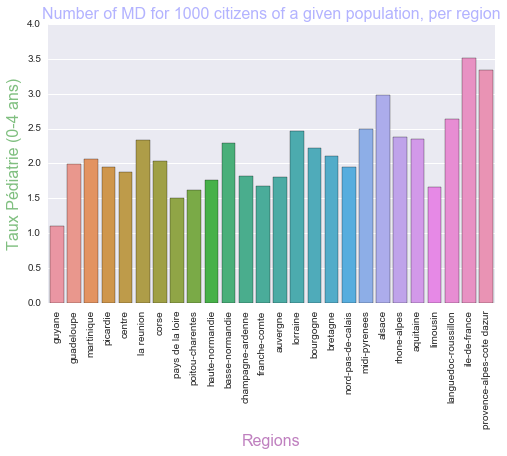

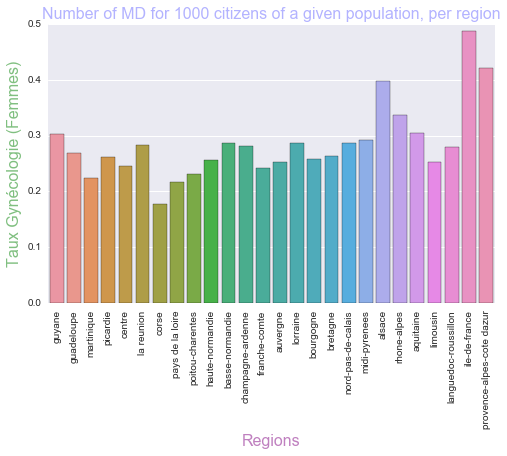

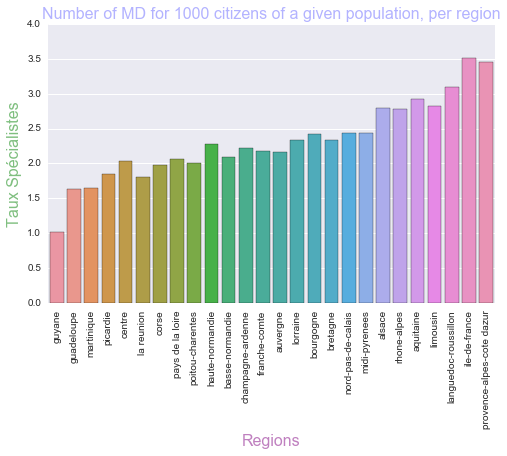

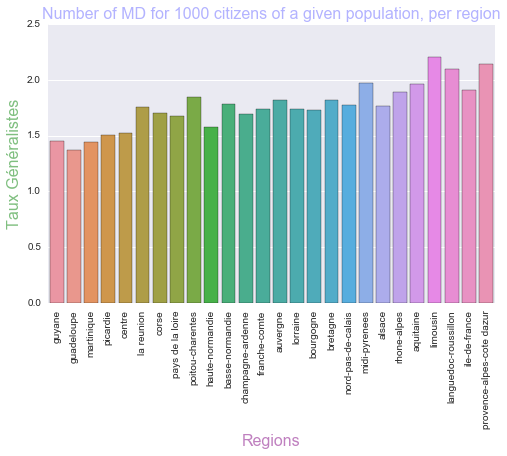

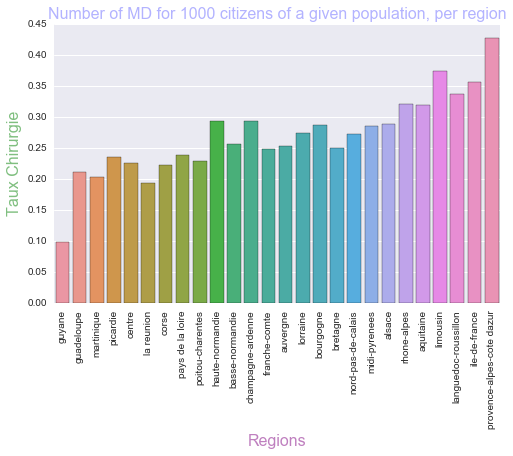

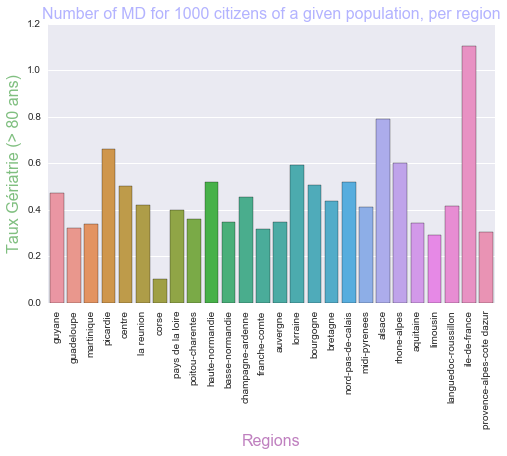

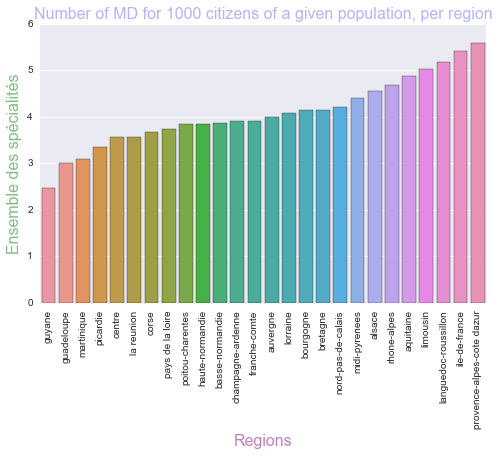

In [40]:
# 
for label in df_res.columns[1:]:
    draw_res(label)

In [21]:
df_merge.columns[1:41]

Index(['De 0 à 4 ans\nHommes\nRP2013', 'De 0 à 4 ans\nFemmes\nRP2013',
       'De 5 à 9 ans\nHommes\nRP2013', 'De 5 à 9 ans\nFemmes\nRP2013',
       'De 10 à 14 ans\nHommes\nRP2013', 'De 10 à 14 ans\nFemmes\nRP2013',
       'De 15 à 19 ans\nHommes\nRP2013', 'De 15 à 19 ans\nFemmes\nRP2013',
       'De 20 à 24 ans\nHommes\nRP2013', 'De 20 à 24 ans\nFemmes\nRP2013',
       'De 25 à 29 ans\nHommes\nRP2013', 'De 25 à 29 ans\nFemmes\nRP2013',
       'De 30 à 34 ans\nHommes\nRP2013', 'De 30 à 34 ans\nFemmes\nRP2013',
       'De 35 à 39 ans\nHommes\nRP2013', 'De 35 à 39 ans\nFemmes\nRP2013',
       'De 40 à 44 ans\nHommes\nRP2013', 'De 40 à 44 ans\nFemmes\nRP2013',
       'De 45 à 49 ans\nHommes\nRP2013', 'De 45 à 49 ans\nFemmes\nRP2013',
       'De 50 à 54 ans\nHommes\nRP2013', 'De 50 à 54 ans\nFemmes\nRP2013',
       'De 55 à 59 ans\nHommes\nRP2013', 'De 55 à 59 ans\nFemmes\nRP2013',
       'De 60 à 64 ans\nHommes\nRP2013', 'De 60 à 64 ans\nFemmes\nRP2013',
       'De 65 à 69 ans\nHommes\nR

In [42]:
Y = df_merge['Gynécologie médicale']
#X = pre.scale(df_merge[df_merge.columns[1:41]])
X = df_merge[df_merge.columns[1:41]]

skl_linmod = lm.LinearRegression(fit_intercept=True) 
skl_linmod.fit(X, Y) # Fit regression model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
df_coef = pd.DataFrame(skl_linmod.coef_, columns=["Theta"])
label_text = ["" for x in range(0,40)]
for i in range(0, 20):
        label_text[2 * i] = "H " + str(i * 5 + 4)
        label_text[2 * i + 1] = "F " + str(i * 5 + 4)

df_coef['Label'] = pd.Series(label_text, index=df_coef.index)


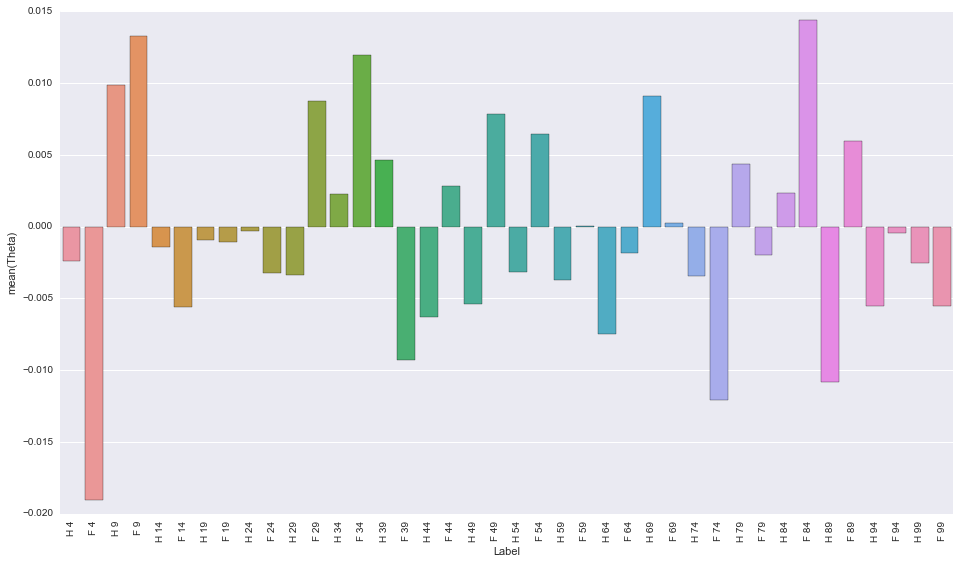

In [44]:
# Draw Figures with split per region
fig, ax = plt.subplots(figsize=(16, 9))
g = sns.barplot(y="Theta", x="Label", data=df_coef, ax=ax)
for label in g.get_xticklabels():
    label.set_rotation(90)


In [28]:
g = sns.JointGrid(x='De 0 à 4 ans\nHommes\nRP2013', y=, data=df_res2)  
g.plot_joint(sns.regplot, order=2)  
g.plot_marginals(sns.distplot)  

SyntaxError: invalid syntax (<ipython-input-28-d1f75219cbfe>, line 1)

In [29]:
df_actes_ = pd.read_csv("./N201607.csv", sep=',')
df_actes = df_actes_.dropna()

CParserError: Error tokenizing data. C error: Expected 5 fields in line 3670, saw 6
